# Sequence to Sequence (seq2seq) variable length and Attention

The most popular sequence-to-sequence task is translation: usually, from one natural language to another. In the last couple of years, commercial systems became surprisingly good at machine translation - check out, for example, Google Translate, Yandex Translate, DeepL Translator, Bing Microsoft Translator.

More information on the lecture and [here](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html) (basics+attention part)

In [2]:
import unicodedata
import re
import numpy as np
import pandas as pd
import os
import io
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Data

The data is available here: http://www.manythings.org/anki/. They consist of a set of pairs in the following format:

  `May I borrow this book?`  `¿Puedo tomar prestado este libro?`

There are a variety of languages available, English-Spanish data will be used.

The processing of the data will consist of the following steps:

1. Removal of special characters
1. adding a start or end token to each sentence.
1. Creating the vectorizer for each of the two languages

In [5]:
# Data download
def download_nmt(corpus="spa-eng"):
    path_to_zip = tf.keras.utils.get_file(corpus+".zip",
                                          origin="http://storage.googleapis.com/download.tensorflow.org/data/"+corpus+".zip",
                                          extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file

file_path = download_nmt()

2638744/2638744 [==============================] - 0s 0us/step


In [6]:
# Process the data
# just removing some caracters to reduce the number of data

def step1(sent):
    # sent = on sentence in a language
    def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    sent = unicode_to_ascii(sent.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)

    return '<start> ' + sent.strip() + ' <end>' # Suppress extra space

In [7]:
# Loading data
def read_data(path, num_examples, split=0.2):
    # path : path to spa-eng.txt file
    # num_examples : Limit the total number of training example for faster training (set num_examples = len(lines) to use full data)
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    english_sentences, spanish_sentences= zip(*[[step1(sent) for sent in l.split('\t')]  for l in lines[:int((1+split)*num_examples)]])

    return np.array(spanish_sentences), np.array(english_sentences)

num_examples = 700 # of which 100 for testing

spanish_sentences, english_sentences = read_data(file_path, num_examples, split=0.0)
test_spanish_sentences = spanish_sentences[num_examples-100:]
test_english_sentences = english_sentences[num_examples-100:]
spanish_sentences = spanish_sentences[:num_examples-100]
english_sentences = english_sentences[:num_examples-100]
spanish_sentences[100], english_sentences[100]

('<start> salga de aqui ! <end>', '<start> go away ! <end>')

In [8]:
# Search vocabulary and max_length for each language
def voc(lang):
    # a list of sentences in the same language
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])  

    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_spanish, vocab_spanish, vocab_size_spanish = voc(spanish_sentences)
max_length_english, vocab_english, vocab_size_english = voc(english_sentences)

In [9]:
pd.DataFrame({"lang":["english", "spanish"],
              "max_length":[max_length_english, max_length_spanish],
              "vocab_size": [vocab_size_english, vocab_size_spanish]}).head()

,lang,max_length,vocab_size
0,english,7,279
1,spanish,8,548


In [10]:
# Build vectorizer layer
english_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_english,
                                              name="English_vect")
# On peut connaitre le vocabulaire par english_vectorizer.get_vocabulary()

# Do the same for spanish
spanish_vectorizer = layers.TextVectorization(standardize=None, output_mode='int',
                                              vocabulary=vocab_spanish,
                                              name="Spanish_vect")

In [11]:
# spanish_vectorizer.get_vocabulary()

In [12]:
BATCH_SIZE = 32
embedding_dim = 50
latent_dim = 64 # final dimension of the encoder in seq2seq
dropout=0.3

## Training model

In [13]:
attention_func = 'MLP' # others possibility: 'dot', 'bilinear', 'MLP'

In [14]:
""" Encoder part """
encoder_inputs = layers.Input(shape=(1,), dtype=tf.string, name="spanish")
encoder_vectorizer = spanish_vectorizer(encoder_inputs)
encoder_embedding = layers.Embedding(vocab_size_spanish, embedding_dim, 
                                     name="spanish_embedding")(encoder_vectorizer)
encoder_outputs, encoder_state_h, encoder_state_c = layers.LSTM(latent_dim, return_sequences=True, return_state=True,
                           dropout=dropout, recurrent_dropout=dropout, name="encoder")(encoder_embedding)

# inject encoder_state_h, encoder_state_c to the initial state of the decoder

# We discard `encoder_outputs` and only keep the states. 
encoder_states = [encoder_state_h, encoder_state_c]

print(encoder_outputs.shape)

# the second dim is none bcz we dont know in the beginiing the length of the sentence

(None, None, 64)


In [15]:
""" Decoder part """
# Set up the decoder, using `encoder_states` as initial state. 
decoder_inputs = layers.Input(shape=(None,), dtype=tf.int32, name="english_teacher")
decoder_embedding = layers.Embedding(vocab_size_english, embedding_dim,
                                     name="english_embedding")(decoder_inputs)
decoder_outputs, decoder_state_h, decoder_state_c = layers.LSTM(latent_dim, return_sequences=True, return_state=True,
                                                                dropout=dropout, recurrent_dropout=dropout, name="Decoder")(decoder_embedding, initial_state=encoder_states)

print(decoder_outputs.shape)

(None, None, 64)


 ![General computation scheme](https://lena-voita.github.io/resources/lectures/seq2seq/attention/computation_scheme-min.png)

In [16]:
""" Attentional part """
# We use all encoder ouput

if attention_func=='dot':
    # Scoring funtion Dot
    print("dot")
    attention = layers.dot([decoder_outputs, encoder_outputs], axes=[2,2], name="Attention_score")
elif attention_func=='bilinear':
    # Scoring function Bilinear
    print("bilinear")
    attention = layers.Dense(latent_dim, activation="linear", name="dense_bilinear")(encoder_outputs)
    attention = layers.dot([decoder_outputs, attention], axes=[2,2], name="Attention_score")
elif attention_func=="MLP":
    # Scoring function MLP - need to know encoder_max_len / decoder_max_len
    print("MLP")
    attention_encoder = layers.Dense(latent_dim, activation="tanh", name="dense_encoder")(encoder_outputs)
    attention_decoder = layers.Dense(latent_dim, activation="tanh", name="dense_decoder")(decoder_outputs)
    attention = layers.dot([attention_decoder, attention_encoder], axes=[2,2], name="Attention_score")

if attention_func is not None:
    attention = layers.Activation('softmax', name="Attention_weight")(attention)
    print(attention.shape)

MLP
(None, None, None)


In [17]:
""" Context vector """
if attention_func is not None:
    context = layers.dot([attention, encoder_outputs], axes=[2,1], name="Attention_output")
    print(context.shape)

(None, None, 64)


In [18]:
""" Combine attention with decoder ouput """
if attention_func is None:
    print("without attention")
    decoder_combined_context = decoder_outputs
else:
    print("with attention")
    decoder_combined_context = layers.concatenate([context, decoder_outputs], name="Luong_Attention")
print(decoder_combined_context.shape)

with attention
(None, None, 128)


In [19]:
""" Ouput of the model """
ouputs = layers.Dense(vocab_size_english, activation='softmax', name="Output")(decoder_combined_context)
print(decoder_outputs.shape)

(None, None, 64)


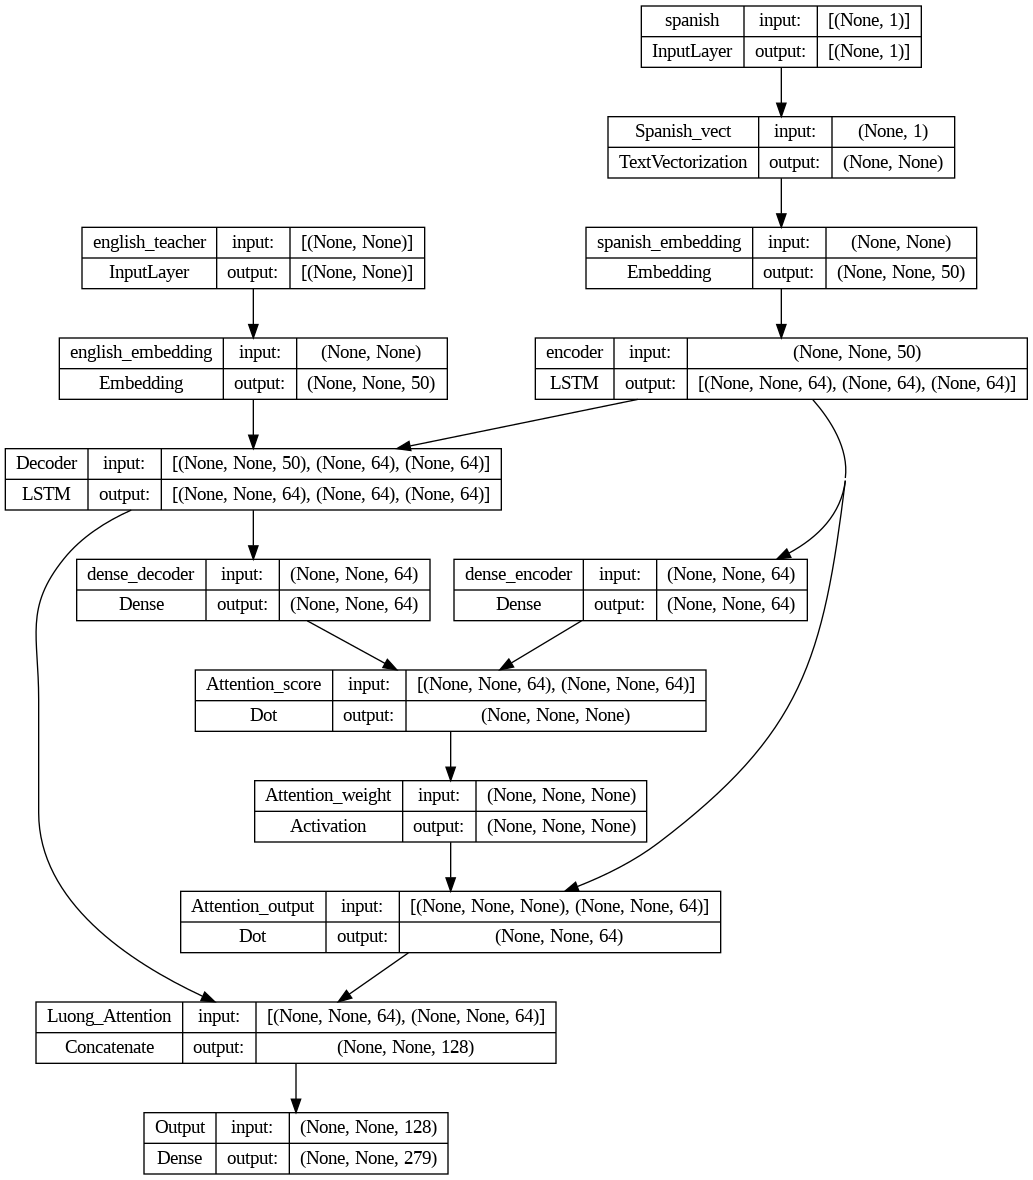

In [20]:
""" The model """
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], ouputs)

plot_model(model, show_shapes=True)

In [21]:
# Prepare training data with teacher forcing
# decoder_input_data is a 2D array of shape (None, None) containing a tokenization of the English sentences.
# decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t] will be the same as decoder_input_data[:, t-1].

english_teacher_enc = english_vectorizer(english_sentences).numpy() # Teacher
english_target_enc = np.zeros_like(english_teacher_enc)
english_target_enc[:,:-1] = english_teacher_enc[:,1:] # To predict
english_target_enc.shape

(600, 7)

In [22]:
#model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# if you dont one hot encode we use sparse_categorical_crossentropy 
# if use one hot encode

<font color=red>
We voluntarily choose to stop on loss in order to have overfitting: too little data to train (or too long training time if we take more data).

Obviously in real life... this is not something to do.

Nevertheless, we keep a validation set to see the overtraining
</font>

In [23]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [EarlyStopping(monitor='loss', mode='min', min_delta=0.000001,
                                patience=5, restore_best_weights=True, verbose=1,
                                )]
history = model.fit([spanish_sentences, english_teacher_enc], english_target_enc,
                    validation_split=0.1,
                    epochs=1000, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)


#dont use th evlaidation split in real problem only use training set

Epoch 1/1000
17/17 [==============================] - 9s 86ms/step - loss: 5.3906 - accuracy: 0.3794 - val_loss: 4.6236 - val_accuracy: 0.2857
Epoch 2/1000
17/17 [==============================] - 1s 37ms/step - loss: 2.9817 - accuracy: 0.4032 - val_loss: 2.9478 - val_accuracy: 0.2857
Epoch 3/1000
17/17 [==============================] - 1s 36ms/step - loss: 2.3995 - accuracy: 0.4156 - val_loss: 2.9011 - val_accuracy: 0.2857
Epoch 4/1000
17/17 [==============================] - 1s 37ms/step - loss: 2.2372 - accuracy: 0.4741 - val_loss: 2.6542 - val_accuracy: 0.4333
Epoch 5/1000
17/17 [==============================] - 1s 38ms/step - loss: 2.1482 - accuracy: 0.5233 - val_loss: 2.6909 - val_accuracy: 0.4381
Epoch 6/1000
17/17 [==============================] - 1s 36ms/step - loss: 2.0745 - accuracy: 0.5463 - val_loss: 2.7016 - val_accuracy: 0.4381
Epoch 7/1000
17/17 [==============================] - 1s 37ms/step - loss: 2.0125 - accuracy: 0.5825 - val_loss: 2.7200 - val_accuracy: 0.4381

In [24]:
model.save('seq2seq-attention-variable')

(0.2657064199447632, 0.9312169551849365)

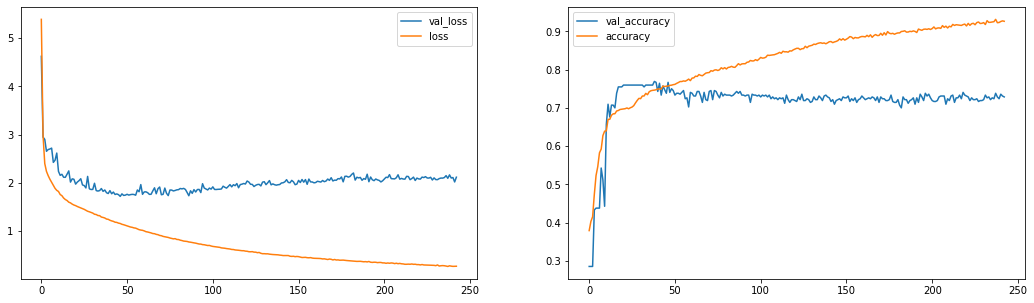

In [25]:
# Babysit the model
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

pd.DataFrame({'val_loss':history.history['val_loss'],
              'loss':history.history['loss'],
             }).plot(ax=ax1)
pd.DataFrame({'val_accuracy':history.history['val_accuracy'],
              'accuracy':history.history['accuracy']
             }).plot(ax=ax2)

min(history.history['loss']), max(history.history['accuracy'])

In [27]:
attention_func

'MLP'

* no attention : (0.170416459441185, 0.9534391760826111)
* dot : (0.19616758823394775, 0.9447090029716492)
* bilinear : (0.266628623008728, 0.9269841313362122)
* MLP : (0.12090284377336502, 0.9666666388511658)

## Inference



In [35]:
print(list(enumerate(english_vectorizer.get_vocabulary())))

[(0, ''), (1, '[UNK]'), (2, 'take'), (3, 'calm'), (4, 'came'), (5, 'next'), (6, 'talked'), (7, 'off'), (8, 'll'), (9, 'fire'), (10, 'saw'), (11, 'do'), (12, 'oh'), (13, 'hard'), (14, 'look'), (15, 'gave'), (16, 'cheer'), (17, 'died'), (18, 'angry'), (19, 'laughed'), (20, 'like'), (21, 'quit'), (22, 'sad'), (23, 'cringed'), (24, 'fly'), (25, 'won'), (26, 'he'), (27, 'fair'), (28, 'bless'), (29, 'goodbye'), (30, 'failed'), (31, 'they'), (32, 'join'), (33, 'find'), (34, 'him'), (35, 'awesome'), (36, 'wept'), (37, 'okay'), (38, 'keep'), (39, 'runs'), (40, 'knew'), (41, 'feel'), (42, 'sing'), (43, 'fat'), (44, 'birds'), (45, 'crazy'), (46, 'after'), (47, 'try'), (48, 'wake'), (49, 'how'), (50, 'watch'), (51, 'hit'), (52, 'swam'), (53, 'love'), (54, 'kiss'), (55, 't'), (56, 'over'), (57, 'grab'), (58, 'hop'), (59, 'walk'), (60, 'full'), (61, 'on'), (62, 'ran'), (63, 'mean'), (64, 'shaved'), (65, 'for'), (66, 'to'), (67, 'show'), (68, 'am'), (69, 'tripped'), (70, 'thanks'), (71, 'perfect'), (

In [36]:
# To decode, you have to transform an integer into a word.
token2word = {token:word for token, word in enumerate(english_vectorizer.get_vocabulary())}
word2token = {v:k for k, v in token2word.items()}

def decode_english_sentence(lang):
    return " ".join([token2word[t] for t in lang]).strip()

In [37]:
i2w = {token:word for token, word in enumerate(spanish_vectorizer.get_vocabulary())}
#wi = {v:k for k, v in i2w.items()}

In [38]:
def translate(spanish_sent, preprocessing=False):
    # Encode the input as state vectors.
    if not preprocessing:
        spanish_sent = step1(spanish_sent)
    
    # Sampling loop for decoding one sentence.
    stop_condition = False
    steps = 0
    
    # Build teacher for first step i.e. populate the first word of target sequence with "<start>".
    target_seq = np.zeros(((1, max_length_english)))
    target_seq[0, steps] = word2token["<start>"]
    
    while not stop_condition:        
        # Predict
        predicted_tokens = model.predict([np.array(spanish_sent, ndmin=2), target_seq], verbose=0)
        predicted_tokens = np.argmax(predicted_tokens, axis=2)
        
        # Sample a token
        sampled_token_index = predicted_tokens[0, steps]
        
        # Update the target sequence.
        steps += 1
        target_seq[0, steps] = sampled_token_index
        
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_token_index==word2token['<end>'] or steps==max_length_english-1:
            stop_condition = True
    return decode_english_sentence(target_seq[0])

In [39]:
# Allows you to search for the correct phrases.
from tqdm import tqdm

correct = []
incorrect = []
for i, (spanish_sent, english_sent) in tqdm(enumerate(zip(spanish_sentences, english_sentences))):
    decoded_sentence = translate(spanish_sent)
    decoded = english_vectorizer(decoded_sentence).numpy()
    original = english_vectorizer(english_sent).numpy()
    if len(decoded)==len(original) and sum(decoded==original)==len(original):
        correct += [i]
    else:
        incorrect += [i]

600it [03:51,  2.59it/s]


In [40]:
len(correct), len(correct)/len(spanish_sentences)*100

(112, 18.666666666666668)

On train set:
* with variable length (208, 34.66)
* with MLP attention and variable length (218, 36.333333333333336)

In [41]:
# Decodes selected correct sentences
for spanish_sent, english_sent in zip(spanish_sentences[correct[-10:]], english_sentences[correct[-10:]]):
    print("="*50)
    print(spanish_sent, "-->", english_sent)
    decoded_sentence = translate(spanish_sent)
    print(english_sent, "???", decoded_sentence)

<start> el es viejo . <end> --> <start> he is old . <end>
<start> he is old . <end> ??? <start> he is old . <end>
<start> el es anciano . <end> --> <start> he is old . <end>
<start> he is old . <end> ??? <start> he is old . <end>
<start> el se afeito . <end> --> <start> he shaved . <end>
<start> he shaved . <end> ??? <start> he shaved . <end>
<start> es rico . <end> --> <start> he s rich . <end>
<start> he s rich . <end> ??? <start> he s rich . <end>
<start> ¿ como esta tom ? <end> --> <start> how s tom ? <end>
<start> how s tom ? <end> ??? <start> how s tom ? <end>
<start> te lo ruego . <end> --> <start> i beg you . <end>
<start> i beg you . <end> ??? <start> i beg you . <end>
<start> te lo suplico . <end> --> <start> i beg you . <end>
<start> i beg you . <end> ??? <start> i beg you . <end>
<start> tire la toalla . <end> --> <start> i gave up . <end>
<start> i gave up . <end> ??? <start> i gave up . <end>
<start> te entiendo . <end> --> <start> i get you . <end>
<start> i get you . <e

In [42]:
# Decodes selected incorrect sentences
for spanish_sent, english_sent in zip(spanish_sentences[incorrect[-10:]], english_sentences[incorrect[-10:]]):
    print("="*50)
    print(spanish_sent, "-->", english_sent)
    decoded_sentence = translate(spanish_sent)
    print(english_sent, "???", decoded_sentence)

<start> estoy quebrado . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> i m fat . <end>
<start> estoy sin blanca . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> i m fat . <end>
<start> no tengo blanca . <end> --> <start> i m broke . <end>
<start> i m broke . <end> ??? <start> don t go . <end>
<start> estoy loco . <end> --> <start> i m crazy . <end>
<start> i m crazy . <end> ??? <start> i m fat . <end>
<start> estoy borracho . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m fat . <end>
<start> estoy tomada . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m fat . <end>
<start> estoy prendida . <end> --> <start> i m drunk . <end>
<start> i m drunk . <end> ??? <start> i m fat . <end>
<start> me estoy muriendo . <end> --> <start> i m dying . <end>
<start> i m dying . <end> ??? <start> i moved . <end>
<start> soy el primero . <end> --> <start> i m first . <end>
<start> i m first 

##  Performance on never before seen data

<font color='red'>
    <bold>Warning:</bold> remember that we have overfitted the model and that we are only working on train data... and not test data.
</font>

In [43]:
# Allows you to search for the correct phrases.
from tqdm import tqdm

test_correct = []
for i, (spanish_sent, english_sent) in tqdm(enumerate(zip(test_spanish_sentences, test_english_sentences))):
    decoded_sentence = translate(spanish_sent)
    decoded = english_vectorizer(decoded_sentence).numpy()
    original = english_vectorizer(english_sent).numpy()
    if len(decoded)==len(original) and sum(decoded==original)==len(original):
        test_correct += [i]
len(test_correct), len(test_correct)/len(test_spanish_sentences)*100

100it [00:36,  2.73it/s]


(0, 0.0)

## Plotting attention matrix 

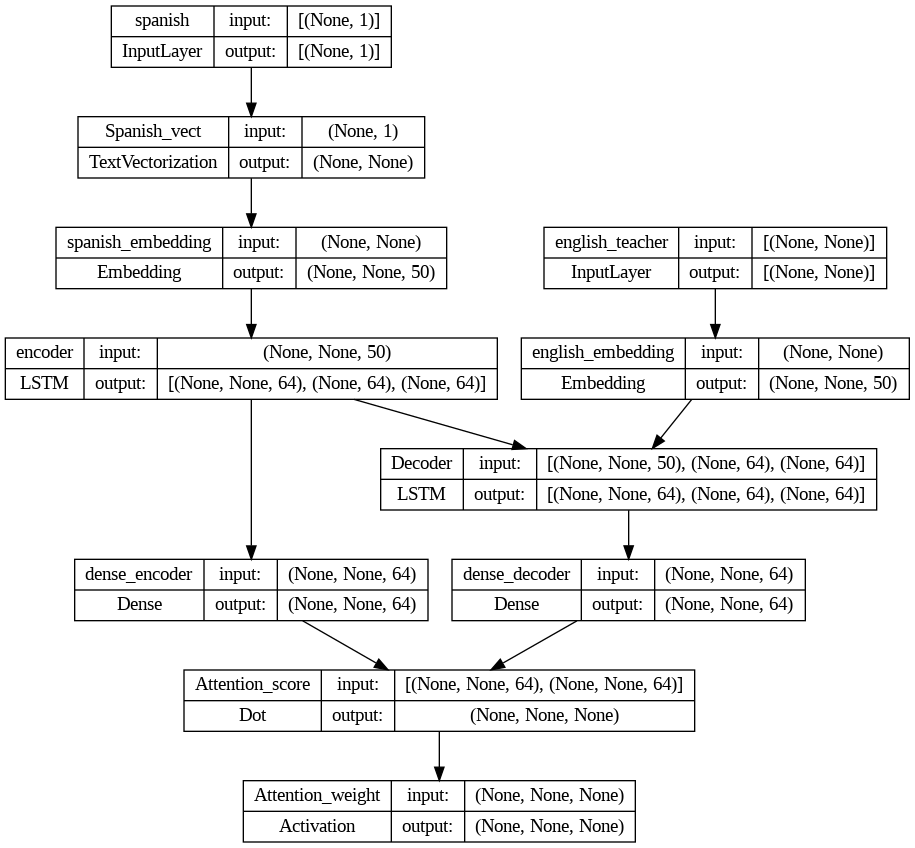

In [44]:
""" The activation matrix is extracted from the previous model. """
attention_model = Model([encoder_inputs, decoder_inputs], attention)
plot_model(attention_model, show_shapes=True)

In [45]:
""" Apply model on one sentence """
id = 74 # 13, 42, 74

1/1 [==============================] - 1s 638ms/step
[1.0000001 1.        1.        1.        1.       ]


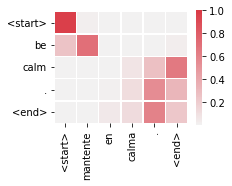

In [46]:
import seaborn as sns

attention_matrix = attention_model.predict([spanish_sentences[id:id+1], english_teacher_enc[id:id+1]])[0]

x_labels = [spanish_vectorizer.get_vocabulary()[i] for i in spanish_vectorizer(spanish_sentences[id]).numpy() if i!=0]
y_labels = [english_vectorizer.get_vocabulary()[i] for i in english_teacher_enc[id][:] if i!=0]
attention_matrix = attention_matrix[:len(y_labels),:len(x_labels)]
print(np.sum(attention_matrix, axis=1))


#x_labels.reverse()
#y_labels.reverse()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(3, 3))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(attention_matrix, vmax=1.0,
            xticklabels=x_labels,
            yticklabels=y_labels,
            cmap=cmap,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .7},
           );


Respective weights between **c** and **h** to predict during the last layer.

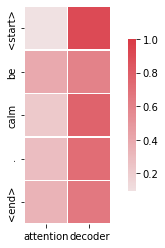

In [47]:
last_layer = model.layers[-1]
weights = last_layer.get_weights()

context_weigths = np.sum(weights[0][:64,:], axis=0)
hidden_weigths = np.sum(weights[0][64:,:], axis=0)

m = np.zeros((len(y_labels), 2))
for i, j in enumerate(english_teacher_enc[id][:len(y_labels)]):
    # Context from attention // Decoder output
    c = abs(context_weigths[j])
    h = abs(hidden_weigths[j])
    #print(context_weigths[j], hidden_weigths[j])
    m[i,:] = [c/(c+h),h/(h+c)]

sns.heatmap(m, vmax=1.0,
            xticklabels=["attention", "decoder"],
            yticklabels=y_labels,
            cmap=cmap,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .7},
           );

In [48]:
for i in english_teacher_enc[id]:
    # Context from attention // Decoder output
    c = abs(context_weigths[i])
    h = abs(hidden_weigths[i])
    #print(context_weigths[i], hidden_weigths[i])
    print(int(100*c/(c+h)), int(100*h/(h+c)))


9 90
39 60
22 77
28 71
33 66
7 92
7 92
